# Introduction 

Credit card fraud detection refers to the process of identifying and preventing unauthorized or fraudulent credit card transactions. Stolen credit cards can be used for illegal purchases or cash withdrawals, impacting both cardholders and the issuing financial institutions. Advances in artificial intelligence and predictive modeling have enabled the development of fraud detection systems that can alert both parties to suspicious activity, and in some cases, even prevent fraudulent transactions from being completed. In this notebook, we will explore various machine learning techniques for detecting and predicting the likelihood of fraudulent credit card transactions.

# Importing necessary Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np
import os
import random 

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score


from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from sklearn.pipeline import Pipeline, make_pipeline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb


# feature selection
from sklearn.feature_selection import SelectKBest, RFECV, f_classif, chi2

# evaluation
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve,
    auc
)

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

# Other configs
sns.set_style('darkgrid'); #Setting style


Seed Configs for persistent outputs

In [2]:
seed = 1337

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Chapter one: Credit Card Fraud Dataset

In [3]:
import pandas as pd
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


# Chapter Two: Exploratory Data Analysis

Check null values

In [6]:
df.isna().sum().sum()

0

Check duplicate values

In [7]:
df.duplicated().sum()

1081

In [8]:
df[df.duplicated()].T

,33,35,113,114,115,221,223,1178,1180,1382,...,282210,282211,282212,282213,282985,282987,283483,283485,284191,284193
Time,26.000000,26.000000,74.000000,74.000000,74.000000,145.000000,145.000000,919.000000,919.000000,1074.000000,...,170731.000000,170731.000000,170731.000000,170731.000000,171288.000000,171288.000000,171627.000000,171627.000000,172233.000000,172233.000000
V1,-0.529912,-0.535388,1.038370,1.038370,1.038370,-2.420413,-2.419486,0.904289,1.207596,-2.248488,...,2.033492,2.033492,2.033492,2.033492,1.916375,1.912550,-1.464380,-1.457978,-2.667936,-2.691642
V2,0.873892,0.865268,0.127486,0.127486,0.127486,1.947885,1.949346,-0.538055,-0.036860,-0.195670,...,0.766969,0.766969,0.766969,0.766969,-0.448919,-0.455240,1.368119,1.378203,3.160505,3.123168
V3,1.347247,1.351076,0.184456,0.184456,0.184456,0.553646,0.552998,0.396058,0.572104,0.026949,...,-2.107555,-2.107555,-2.107555,-2.107555,-1.748434,-1.750654,0.815992,0.811515,-3.355984,-3.339407
V4,0.145457,0.147575,1.109950,1.109950,1.109950,0.983069,0.982710,0.500680,0.373148,-0.525780,...,3.631952,3.631952,3.631952,3.631952,0.452716,0.454324,-0.601282,-0.603760,1.007845,1.017018
V5,0.414209,0.433680,0.441699,0.441699,0.441699,-0.281518,-0.284815,-0.864473,-0.709633,-0.238759,...,1.348594,1.348594,1.348594,1.348594,2.091083,2.089130,-0.689115,-0.711883,-0.377397,-0.293095
V6,0.100223,0.086983,0.945283,0.945283,0.945283,2.408958,2.411200,-0.657199,-0.713698,-0.033359,...,-0.499907,-0.499907,-0.499907,-0.499907,4.159306,4.160019,-0.487154,-0.471672,-0.109730,-0.167054
V7,0.711206,0.693039,-0.036715,-0.036715,-0.036715,-1.401613,-1.398537,0.027231,-0.181105,0.162196,...,0.945159,0.945159,0.945159,0.945159,-0.883930,-0.881302,-0.303778,-0.282535,-0.667233,-0.745886
V8,0.176066,0.179742,0.350995,0.350995,0.350995,-0.188299,-0.188922,-0.029473,0.011277,0.928520,...,-0.286392,-0.286392,-0.286392,-0.286392,1.082264,1.081750,0.884953,0.880654,2.309700,2.325616
V9,-0.286717,-0.285642,0.118950,0.118950,0.118950,0.675878,0.675695,0.265447,0.283940,-0.424215,...,-1.370581,-1.370581,-1.370581,-1.370581,1.023162,1.022928,0.054065,0.052808,-1.639306,-1.634651


In [34]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [9]:
print('Before dropping duplicates: ', df.shape)
df = df.drop_duplicates()
print('After dropping duplicates: ', df.shape)

Before dropping duplicates:  (284807, 31)
After dropping duplicates:  (283726, 31)


## Checking distribution of the Target column

In [10]:
df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

<Axes: xlabel='Class', ylabel='count'>

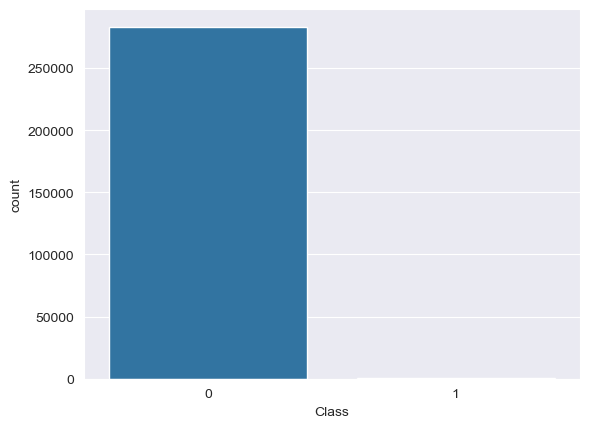

In [11]:
sns.countplot(df, x='Class')

In [12]:
round((473/283253 * 100), 3)

0.167

The dataset is highly unbalanced, the positive class (frauds) account for 0.167% of all transactions.

## Checking the distribution of Transaction Amount column

In [ ]:
sns.displot(df, x='Amount', kind='kde')

In [ ]:
df[df['Class'] == 1]['Amount'].min(), df[df['Class'] == 1]['Amount'].max()

In [ ]:
df.loc[
    (df['Class']==1) & (df['Amount']==0)
]

There are 25 records, which are labelled as 1 (Fraud) but the amount is 0. Thats interesting!

In [ ]:
df['Amount'].quantile(.99), df['Amount'].quantile(.50), 

In [ ]:
fraud = df[df['Class']==1]
not_fraud = df[~(df['Class']==1)]
fraud.shape, not_fraud.shape

In [ ]:
fraud['Amount'].quantile(.99), fraud['Amount'].quantile(.50), fraud['Amount'].max()

In [ ]:
fraud[['Time', 'Class', 'Amount']].describe()

In [ ]:
not_fraud[['Time', 'Class', 'Amount']].describe()

Here, it is noticed that the fraudulent transactions that mostly occur for the smaller amounts. We still see the max amount being 2125.87.  
99% of the fraudulent transactions were around 1364.13 while 50% being lower than 9.82.

In [ ]:
sns.scatterplot(fraud, x='Time', y='Amount')
plt.xlabel('Time (seconds)')
plt.ylabel('Fraud Occurrence')
plt.title('Fraud Transaction Timeline')

## Univariate Analysis

In [ ]:
(len(df.columns) - 3) // 4

In [75]:
features = df.drop(columns=['Time', 'Class', 'Amount']).columns

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(16, 20))

for ax, col in zip(axes.flat, features):
    sns.histplot(df, x=col, ax=ax)

plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(16, 20))

for ax, col in list(zip(axes.flat, features)):   
    sns.boxplot(x=df[col], ax=ax)

## Outlier Detection

As we can see that, box plots using IQR method cannot be used on this dataset for the outliers.  
We fill need to find the outliers using a different technique.

In [ ]:
from scipy.stats import zscore
z_threshold = 3
zscore_df = df.drop(columns=['Class']).apply(zscore)
zscore_df = zscore_df.abs() > z_threshold
zscore_df = zscore_df.any(axis=1)
outlier_rows = df[zscore_df]
outlier_rows

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
18,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,...,-0.503600,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0
38,29.0,0.996370,-0.122589,0.546819,0.706580,0.134560,1.156995,-0.294561,0.407429,0.337863,...,-0.076302,0.108867,0.162231,-0.575624,0.109795,0.373813,0.050552,0.005106,20.53,0
51,36.0,-1.004929,-0.985978,-0.038039,3.710061,-6.631951,5.122103,4.371691,-2.006868,-0.278736,...,1.393406,-0.381671,0.969719,0.019445,0.570923,0.333278,0.857373,-0.075538,1402.95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284795,172778.0,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,9.87,0
284798,172782.0,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,24.05,0
284799,172783.0,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,79.99,0
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0


<Axes: xlabel='Class', ylabel='count'>

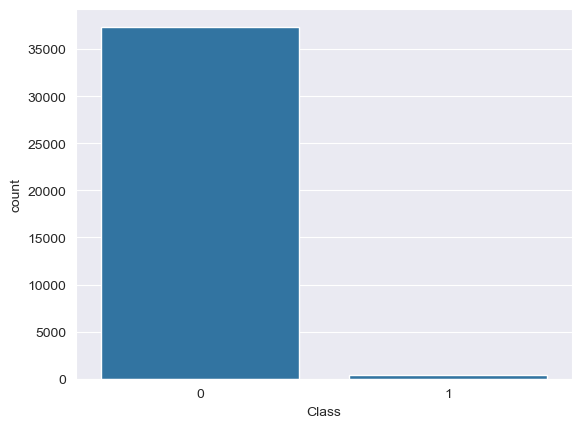

In [26]:
sns.countplot(outlier_rows, x='Class')

In [32]:
outlier_rows['Class'].value_counts()

Class
0    37372
1      444
Name: count, dtype: int64

In [41]:
z_threshold = 3
zscore_df = df.drop(columns=['Class']).apply(zscore)
zscore_df = zscore_df.abs() > z_threshold
zscore_df = zscore_df.any(axis=1)
outlier_rows = df[zscore_df]
outlier_rows['Class'].value_counts()

Class
0    37372
1      444
Name: count, dtype: int64

## Checking Correlation of Target column with Features

In [81]:
# Correlation with target
correlations = df.corr()['Class']
print("Correlations with Class:")
print(correlations.sort_values())

Correlations with Class:
V17      -0.313498
V14      -0.293375
V12      -0.250711
V10      -0.206971
V16      -0.187186
V3       -0.182322
V7       -0.172347
V18      -0.105340
V1       -0.094486
V9       -0.094021
V5       -0.087812
V6       -0.043915
Time     -0.012359
V24      -0.007210
V23      -0.006333
V13      -0.003897
V15      -0.003300
V25       0.003202
V26       0.004265
V22       0.004887
Amount    0.005777
V28       0.009682
V20       0.021486
V27       0.021892
V21       0.026357
V8        0.033068
V19       0.033631
V2        0.084624
V4        0.129326
V11       0.149067
Class     1.000000
Name: Class, dtype: float64


Here we are trying to find which PCA component have stronger correlation with our Target (Fraud/Not Fraud).   
Correlations can be both positive and negative depeding on how they influence the outcome.

<Axes: xlabel='V17', ylabel='V14'>

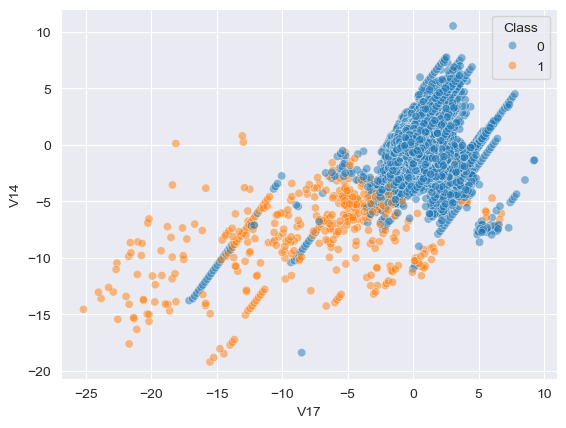

In [73]:
# Top 2 highest correlated columns
sns.scatterplot(x='V17', y='V14', hue='Class', data=df, alpha=0.5)

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(16, 20))
for ax, col in zip(axes.flat, features):
    sns.histplot(fraud, x=col, ax=ax, kde=True)

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(16, 20))

for ax, col in list(zip(axes.flat, features)):   
    sns.boxplot(x=fraud[col], ax=ax)

In [ ]:
sns.scatterplot(data=df, x='V3', y='V10', hue='Class')
plt.show()

In [88]:
# get column names with highest correlation to 'Class'
correlations.sort_values().head(10).index

array(['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V18', 'V1', 'V9'],
      dtype=object)

Trying to plot the scatter plot of correlated features to understand how they differ for fraud and not fraud class

In [93]:
# permutation, combination
from itertools import combinations
# Generate all combinations of features
feature_combinations = list(combinations(correlations.sort_values().head(5).index, 2))
len(feature_combinations)

10

c:\Users\Gadge\anaconda3\lib\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\Gadge\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


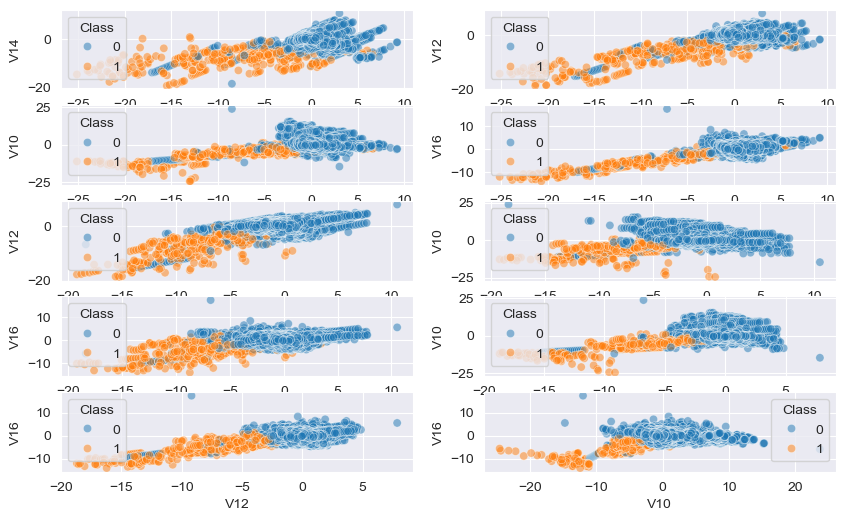

In [94]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
for ax, col in zip(axes.flat, range(len(feature_combinations))):
    sns.scatterplot(
        data=df, 
        x=feature_combinations[col][0], y=feature_combinations[col][1], 
        hue='Class', alpha=0.5, ax=ax
    )
    plt.title(f"{feature_combinations[col][0]} vs {feature_combinations[col][1]}")

### Interclass correlation with features with Mann-Whitney U test

Mann-Whitney U test is a non-parametric test which is more suitable for imbalanced datasets like this.   
It measures the correlation for each class i.e. Fraud and Not Fraud with all the features.

In [ ]:
from scipy.stats import mannwhitneyu

# print("Mann-Whitney U Test Results:")
mannwhitney_score = []
for col in df.columns[:-1]:  
    stat, p = mannwhitneyu(not_fraud[col], 
                          fraud[col])
    mannwhitney_score.append({
        'col': col,
        'stat': stat,
        'p-value': p,
    })
    # print(f"{col}: stat = {stat:.4e} p-value = {p:.4e}")
    
mannwhitney_score_df = pd.DataFrame(mannwhitney_score).sort_values(by='p-value')
mannwhitney_score_df

Low p-values means that there is a significant difference in feature distributions between the classes present in our target column.   

#### Bonferroni Correction

As we are doing multiple test, we need to correct the p-values in order to reduce Type-I error.  

In [ ]:
# Apply Bonferroni correction (optional)
alpha = 0.05 / (len(df.columns) - 1)
print(f"Bonferroni: {alpha:.4e}")

In [70]:
mannwhitney_score_df['is_significant'] = mannwhitney_score_df['p-value'].apply(lambda x: '*' if x < alpha else '')
mannwhitney_score_df

NameError: name 'mannwhitney_score_df' is not defined

# Chapter Three: Data Preprocessing

## Split into Train-Test-Val

In [6]:
y = df['Class']
X = df.drop(columns=['Class'])
X.shape, y.shape

((284807, 30), (284807,))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=seed
)

X_test, X_val, y_test, y_val = train_test_split(
    X_val, y_val,
    stratify=y_val,
    test_size=0.5,
    random_state=seed
)

In [8]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((227845, 30), (28481, 30), (28481, 30), (227845,), (28481,), (28481,))

In [9]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(Class
 0    227451
 1       394
 Name: count, dtype: int64,
 Class
 0    28432
 1       49
 Name: count, dtype: int64,
 Class
 0    28432
 1       49
 Name: count, dtype: int64)

In [10]:
upsampler = SMOTE(random_state=42)
X_train_smote, y_train_smote = upsampler.fit_resample(X=X_train, y=y_train)
y_train_smote.value_counts()

Class
0    227451
1    227451
Name: count, dtype: int64

In [11]:
len(X_train_smote), len(y_train_smote)

(454902, 454902)

In [12]:
# sns.displot(X_train, x='V1', y='V2', hue=y_train, kind='kde', norm_hist=True)
# plt.show()
# sns.displot(X_train_smote, x='V3', y='V4', hue=y_train_smote, kind='kde', norm_hist=True)
# plt.show()

# Chapter Four: Modelling

## Utility Functions

In [13]:
# We are going to train multiple models, so we will write a function to log our experiments in order to keep track of the results.
# And then we will create a dataframe to compare them
# We will store model name, accuracy, precision, recall, f1-score, roc_auc_score, prc_auc_score and confusion matrix, expertiment title, and description
EXPERIMENTS = []
def log_experiment(model_name, y_pred, y_test, y_pred_probs, title='', params=''):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_probs)
    prc_auc = auc(recall_curve, precision_curve)
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    out = {
        'Model': model_name,
        'Title': title,
        'Parameters': params,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'PRC AUC': prc_auc,
        'Confusion Matrix': confusion_mat,
    }
    EXPERIMENTS.append(out)
    return out

As the dataset is highly imbalanced i doubt the linear models will work any good at all. Although for baseline, I will try to fit logistic regression model.

## Baseline Model

In [20]:
pipe1  = Pipeline((
    ('preprocess', ColumnTransformer([
        ("scaler", StandardScaler(), ["Amount", "Time"]
    )], remainder='passthrough')),
    ('classifier', LogisticRegression(max_iter=1000, random_state=seed)),
))

pipe2 = Pipeline((  
    ('preprocess', ColumnTransformer([
        ("scaler", StandardScaler(), ["Amount", "Time"]
    )], remainder='passthrough')),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=seed)),
))

In [21]:
for data in [(X_train, y_train), (X_train_smote, y_train_smote)]:
    X_data, y_data = data
    pipe1.fit(X_data, y_data)
    y_pred1 = pipe1.predict(X_val)
    pipe2.fit(X_data, y_data)
    y_pred2 = pipe2.predict(X_val)    
    print(f"Accuracy: {pipe1.score(X_val, y_val)*100} %")
    print(classification_report(y_val, y_pred1))
    print(f"Accuracy with class_weight=balanced: {pipe2.score(X_val, y_val)*100} %")
    print(classification_report(y_val, y_pred2))
    print()

Accuracy: 99.90519995786666 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.81      0.59      0.68        49

    accuracy                           1.00     28481
   macro avg       0.90      0.80      0.84     28481
weighted avg       1.00      1.00      1.00     28481

Accuracy with class_weight=balanced: 97.68266563674028 %
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     28432
           1       0.07      0.94      0.12        49

    accuracy                           0.98     28481
   macro avg       0.53      0.96      0.56     28481
weighted avg       1.00      0.98      0.99     28481


Accuracy: 99.16084407148625 %
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28432
           1       0.16      0.92      0.27        49

    accuracy                           0.99     28481
   macro a

Here, it's interesting to see that the accuracy is 99% although you look closely at the classification report, the recall for the class=1, is very low.  
Lets look at the pr curve.


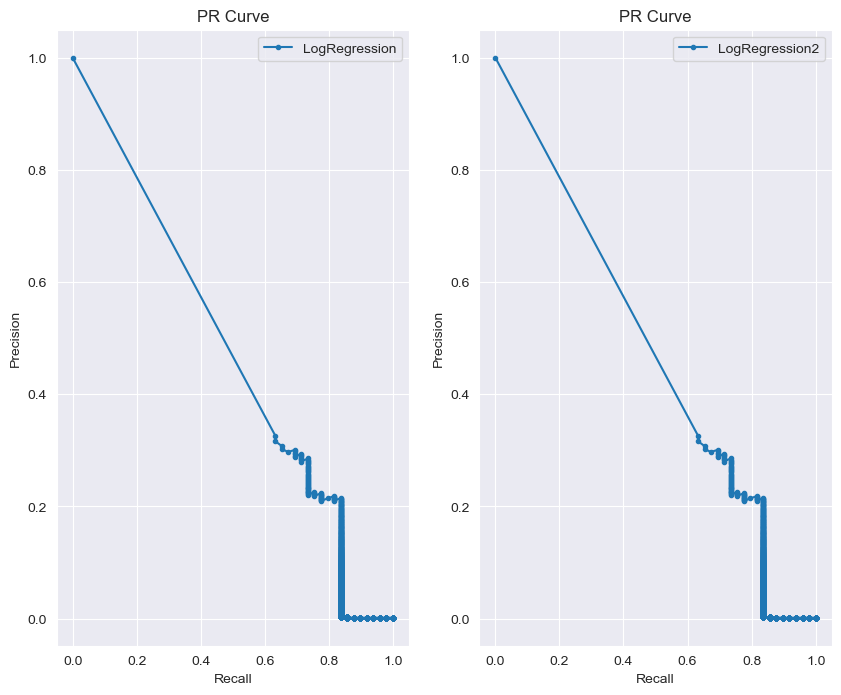

In [22]:
y_pred1_probs = np.max(pipe1.predict_proba(X_val), axis=1)
y_pred2_probs = np.max(pipe2.predict_proba(X_val), axis=1)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
precision, recall, _ = precision_recall_curve(y_val, y_pred1_probs)
# plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='LogRegression')
plt.title('PR Curve') 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_val, y_pred2_probs)
plt.plot(recall, precision, marker='.', label='LogRegression2')
plt.title('PR Curve') 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [23]:
print(pipe1.get_params()['classifier'])
print(pipe2.get_params()['classifier'])

LogisticRegression(max_iter=1000, random_state=1337)
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1337)


In [24]:
log_experiment(
    'LogisticRegression',
    y_pred1,
    y_val,
    y_pred1_probs,
    title='Logistic Regression (Baseline)',
    params=str(pipe1.get_params()['classifier'])
)

log_experiment(
    'LogisticRegression',
    y_pred2,
    y_val,
    y_pred2_probs,
    title='Logistic Regression (Baseline) - class_weight=balanced',
    params=str(pipe2.get_params()['classifier'])
)

{'Model': 'LogisticRegression',
 'Title': 'Logistic Regression (Baseline) - class_weight=balanced',
 'Parameters': "LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1337)",
 'Accuracy': 0.9916084407148625,
 'Precision': 0.16071428571428573,
 'Recall': 0.9183673469387755,
 'F1 Score': 0.2735562310030395,
 'ROC AUC': 0.9550510060523928,
 'PRC AUC': 0.47229532090956483,
 'Confusion Matrix': array([[28197,   235],
        [    4,    45]], dtype=int64)}

In [25]:
pd.DataFrame(EXPERIMENTS)

,Model,Title,Parameters,Accuracy,Precision,Recall,F1 Score,ROC AUC,PRC AUC,Confusion Matrix
0,LogisticRegression,Logistic Regression (Baseline),"LogisticRegression(max_iter=1000, random_state...",0.991608,0.160714,0.918367,0.273556,0.955051,0.472295,"[[28197, 235], [4, 45]]"
1,LogisticRegression,Logistic Regression (Baseline) - class_weight=...,"LogisticRegression(class_weight='balanced', ma...",0.991608,0.160714,0.918367,0.273556,0.955051,0.472295,"[[28197, 235], [4, 45]]"


## Trying Advanced Models

In [ ]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=seed),
    'XgBoost': XGBClassifier(n_estimators=100, device='cuda:0', random_state=seed),
}

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


Training RandomForest model...
RandomForest Accuracy: 99.96 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.89      0.86      0.88        49

    accuracy                           1.00     28481
   macro avg       0.95      0.93      0.94     28481
weighted avg       1.00      1.00      1.00     28481



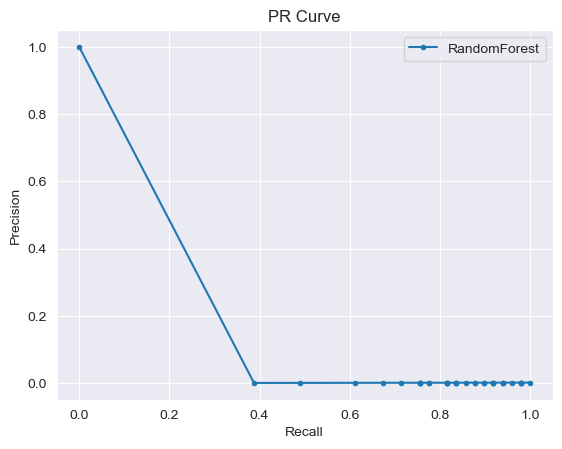

Training XgBoost model...


c:\Users\Gadge\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:11:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XgBoost Accuracy: 99.96 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.90      0.88      0.89        49

    accuracy                           1.00     28481
   macro avg       0.95      0.94      0.94     28481
weighted avg       1.00      1.00      1.00     28481



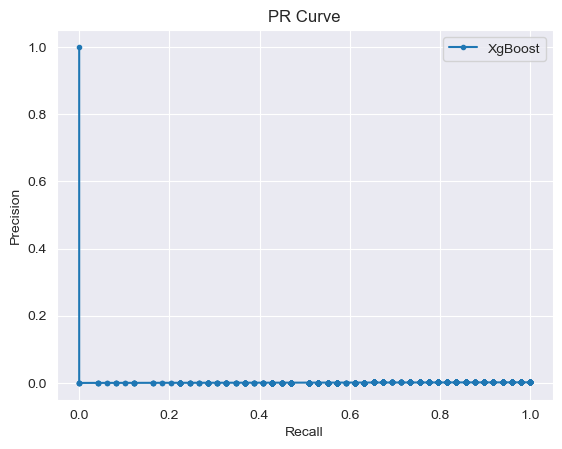

In [28]:
for name, model in models.items():
    print(f"Training {name} model...")
    pipe = Pipeline((
        ('preprocess', ColumnTransformer([
            ("scaler", StandardScaler(), ["Amount", "Time"]
        )], remainder='passthrough')),
        ('classifier', model),
    ))
    
    pipe.fit(X_train_smote, y_train_smote)
    y_pred = pipe.predict(X_val)
    
    print(f"{name} Accuracy: {pipe.score(X_val, y_val)*100:.2f} %")
    print(classification_report(y_val, y_pred))
    
    y_pred_probs = np.max(pipe.predict_proba(X_val), axis=1)
    
    precision, recall, _ = precision_recall_curve(y_val, y_pred_probs)
    plt.plot(recall, precision, marker='.', label=name)
    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    log_experiment(
        name,
        y_pred,
        y_val,
        y_pred_probs,
        title=f'{name} - Basic - SMOTE',
        params=str(pipe.get_params()['classifier'])
    )

In [29]:
EXPERIMENTS_df = pd.DataFrame(EXPERIMENTS)
EXPERIMENTS_df

,Model,Title,Parameters,Accuracy,Precision,Recall,F1 Score,ROC AUC,PRC AUC,Confusion Matrix
0,LogisticRegression,Logistic Regression (Baseline),"LogisticRegression(max_iter=1000, random_state...",0.991608,0.160714,0.918367,0.273556,0.955051,0.472295,"[[28197, 235], [4, 45]]"
1,LogisticRegression,Logistic Regression (Baseline) - class_weight=...,"LogisticRegression(class_weight='balanced', ma...",0.991608,0.160714,0.918367,0.273556,0.955051,0.472295,"[[28197, 235], [4, 45]]"
2,RandomForest,RandomForest - Basic - SMOTE,RandomForestClassifier(random_state=1337),0.999579,0.893617,0.857143,0.875000,0.928483,0.194770,"[[28427, 5], [7, 42]]"
3,XgBoost,XgBoost - Basic - SMOTE,"XGBClassifier(base_score=None, booster=None, c...",0.999614,0.895833,0.877551,0.886598,0.938688,0.001025,"[[28427, 5], [6, 43]]"


## Stratified Cross-Validation

In [37]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cv_scores = {}

for name, clf in models.items():
    scores = cross_val_score(clf, X_train_smote, y_train_smote, cv=skf, scoring='recall', n_jobs=-1)
    cv_scores[name] = {
        'Recall Mean': scores.mean(),
        'Std Dev'    : scores.std()
    }

print(pd.DataFrame(cv_scores).T)

              Recall Mean   Std Dev
RandomForest     0.999996  0.000009
XgBoost          1.000000  0.000000


Interesting that we got 100% recall. This happened due to I passed X_train_smote to cross validation folds. Every fold will have balanced data points then. I should add smote separately for each fold i guess.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cv_scores = {}

for name, clf in models.items():
    cv_pipe = make_pipeline(
        ColumnTransformer([
            ("normalize", Normalizer(), ["Amount", "Time"])
        ], remainder='passthrough'),
        StandardScaler(),
        clf
    )

    # By adding the pipe instead of clf, we can add SMOTE for each fold, instead of passing X_train_smote
    scores = cross_val_score(cv_pipe, X_train, y_train, cv=skf, scoring='recall', n_jobs=-1)
    cv_scores[name] = {
        'Recall Mean': scores.mean(),
        'Std Dev'    : scores.std()
    }

print(pd.DataFrame(cv_scores).T)

              Recall Mean   Std Dev
RandomForest     0.756772  0.062293
XgBoost          0.767228  0.051028


Now, this seems more realistic, to have less than 100% recall, as we did in the previous cell

# Chapter Five: Hyper-Paramter Tuning

In [30]:
num_process = os.cpu_count()//2
num_process

6

In [31]:
models = {
    'LogisticRegression': LogisticRegression(random_state=seed, n_jobs=num_process),
    # 'SVC': SVC(kernel='rbf', probability=True, random_state=seed),
    'RandomForest': RandomForestClassifier(random_state=seed, n_jobs=num_process),
    'XGBoost': XGBClassifier(device='cuda:0', random_state=seed, use_label_encoder=False, n_jobs=num_process),
    'MLP': MLPClassifier(random_state=seed, early_stopping=True),
}

In [32]:
parameter_grid = {
    'LogisticRegression': {
        'clf__class_weight': ['balanced', None],
        'clf__max_iter': [100, 500, 1000],
    },
    'SVC': {
        'clf__C': [0.01, 0.1],
        'clf__class_weight': ['balanced', None],
        'clf__kernel': ['rbf', 'poly'],
    },
    'RandomForest': {
        'clf__n_estimators': [100, 200],
        'clf__criterion': ['entropy', 'gini'],
        'clf__class_weight': ['balanced', None],
    },
    'XGBoost': {
        'clf__n_estimators': [100, 200, 500],
        'clf__learning_rate': [0.001, 0.01]
    },
    'MLP': {
        'clf__hidden_layer_sizes': [(10, 20, 50, 100)],
        'clf__activation': ['relu', 'tanh'],
        'clf__solver': ['adam', 'sgd'],
        'clf__max_iter': [100, 200, 500],
        'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
    }
}

In [33]:
best_models = []
# Use RandomizedSearchCV for faster hyperparameter tuning
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for name, model in models.items():
    # if name in ['LogisticRegression', 'SVC', 'RandomForest']:
    #     # Skip Logistic Regression as we already tuned it
    #     continue
    print(f"Tuning model : {name}...")
    pipe_cv = Pipeline((
        ("preprocessor", ColumnTransformer([
            ("scaler", StandardScaler(), ["Amount", "Time"])
        ], remainder='passthrough')),
        ("clf", model)
    ))

    halving_search_cv = HalvingGridSearchCV(
        pipe_cv,
        parameter_grid[name],
        cv=skf, 
        scoring='recall', 
        n_jobs=-1, 
        verbose=10,
    )

    halving_search_cv.fit(X_train, y_train)

    print(f"Best parameters for {name}: {halving_search_cv.best_params_}")
    print(f"Best score for {name}: {halving_search_cv.best_score_}")
    best_models.append({
        'Model': name,
        'Best Params': halving_search_cv.best_params_,
        'Best Score': halving_search_cv.best_score_
    })

Tuning model : LogisticRegression...
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 75948
max_resources_: 227845
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 75948
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 227844
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for LogisticRegression: {'clf__class_weight': 'balanced', 'clf__max_iter': 500}
Best score for LogisticRegression: 0.9061343719571567
Tuning model : RandomForest...
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 75948
max_resources_: 227845
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 75948
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 3
n_resources: 227844
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Ra

c:\Users\Gadge\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'clf__learning_rate': 0.01, 'clf__n_estimators': 500}
Best score for XGBoost: 0.7716001298279779
Tuning model : MLP...
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 8438
max_resources_: 227845
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 8438
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 12
n_resources: 25314
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 75942
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 227826
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for MLP: {'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (10, 20, 50, 100), 'clf__learning_rate': 'adaptive', 'clf__max_iter': 200, 'clf__solver': 'adam'}
Best score for MLP: 0.7489126906848427


In [34]:
best_models

[{'Model': 'LogisticRegression',
  'Best Params': {'clf__class_weight': 'balanced', 'clf__max_iter': 500},
  'Best Score': 0.9061343719571567},
 {'Model': 'RandomForest',
  'Best Params': {'clf__class_weight': None,
   'clf__criterion': 'gini',
   'clf__n_estimators': 200},
  'Best Score': 0.7817267121064589},
 {'Model': 'XGBoost',
  'Best Params': {'clf__learning_rate': 0.01, 'clf__n_estimators': 500},
  'Best Score': 0.7716001298279779},
 {'Model': 'MLP',
  'Best Params': {'clf__activation': 'tanh',
   'clf__hidden_layer_sizes': (10, 20, 50, 100),
   'clf__learning_rate': 'adaptive',
   'clf__max_iter': 200,
   'clf__solver': 'adam'},
  'Best Score': 0.7489126906848427}]

In [46]:
PRs = {}

In [52]:
for model in best_models:
    name = model.get('Model')
    params = model.get('Best Params')
    print('Name: ', name, ', Parameters:', params)
    params = {
        k.replace('clf__', ''): v if k.startswith('clf__') else v for k, v in params.items()
    }
    print('Training with Parameters: ', params)

    classifier = models[name]
    pipe = Pipeline((
        ("preprocessor", ColumnTransformer([
            ("scaler", StandardScaler(), ["Amount", "Time"])
        ], remainder='passthrough')),
        ("clf", classifier.set_params(**params))
    ))       
    pipe.fit(
        pd.concat([X_train, X_val]),
        pd.concat([y_train, y_val])
    )

    # pipe.fit(X_train_smote, y_train_smote)

    y_pred = pipe.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)} %")
    print(classification_report(y_test, y_pred))
    y_pred_probs = np.max(pipe.predict_proba(X_test), axis=1)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    PRs[name] = {
        'precision': precision,
        'recall': recall,
        'y_pred_probs': y_pred_probs
    }
    # plt.plot(recall, precision, marker='.', label=name)
    # plt.title('PR Curve')
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.legend()
    # plt.show()
    print('='*50)
    log_experiment(
        name,
        y_pred,
        y_test,
        y_pred_probs,
        title=f'{name} - Hyperparameter Tuned - (Train + Val)',
        params=str(pipe.get_params()['clf'])
    )

Name:  LogisticRegression , Parameters: {'clf__class_weight': 'balanced', 'clf__max_iter': 500}
Training with Parameters:  {'class_weight': 'balanced', 'max_iter': 500}
LogisticRegression Accuracy: 0.9783364348161933 %
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     28432
           1       0.07      0.88      0.12        49

    accuracy                           0.98     28481
   macro avg       0.53      0.93      0.56     28481
weighted avg       1.00      0.98      0.99     28481

Name:  RandomForest , Parameters: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__n_estimators': 200}
Training with Parameters:  {'class_weight': None, 'criterion': 'gini', 'n_estimators': 200}
RandomForest Accuracy: 0.9994733330992591 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.95      0.73      0.83        49

    accuracy                           1

c:\Users\Gadge\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9995435553526912 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       1.00      0.73      0.85        49

    accuracy                           1.00     28481
   macro avg       1.00      0.87      0.92     28481
weighted avg       1.00      1.00      1.00     28481

Name:  MLP , Parameters: {'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (10, 20, 50, 100), 'clf__learning_rate': 'adaptive', 'clf__max_iter': 200, 'clf__solver': 'adam'}
Training with Parameters:  {'activation': 'tanh', 'hidden_layer_sizes': (10, 20, 50, 100), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'adam'}
MLP Accuracy: 0.9991573329588147 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.79      0.69      0.74        49

    accuracy                           1.00     28481
   macro avg       0.90      0.85      0.87     

## Tuned Results

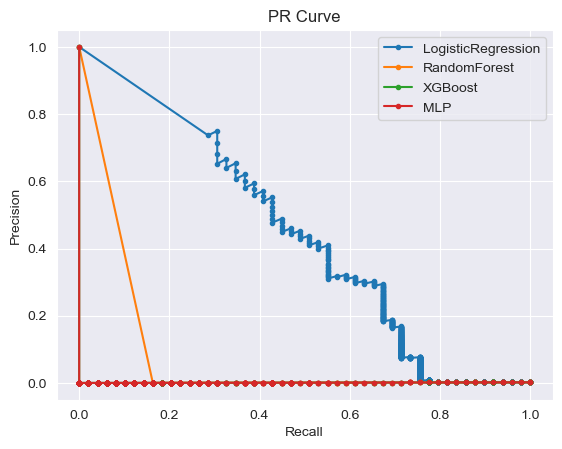

In [53]:
for item in PRs.items():
    # (p, r) = PRs[name]['precision'], PRs[name]['recall']
    # plt.plot(r, p, marker='.', label=name)
    model_name = item[0]
    p, r = item[1]['precision'], item[1]['recall']
    plt.plot(r, p, marker='.', label=model_name)
    plt.title('PR Curve')
    plt.xlabel('Recall')    
    plt.ylabel('Precision')
    plt.legend()    

Observations:
1. Logistic Regression: 
    - For Logistic Regression we got 97% accuracy. 
    - Although the precision and recall for class 1 (Fraud) was 7% and 88% respectively.
    - This implies that, LR was able to catch 88% for the actual frauds. although precision of 7% implies that there were too many false positives.

2. Random Forest:
    - For Random Forest we got 99.95% accuracy.
    - Precision and recall for class 1, for RF was 95% and 73% respectively.
    - The F1 Score came to around 83% which is good. Although, recall is less than logistic regression, meaning it was able to catch less fraud transaction while lowering the false positive count.

3. XGBoost:
    - For XGBoost we also got 99.95% accuracy.
    - Precision and recall for class 1, for RF was 100% and 73% respectively.
    - Similar to RandomForest, it was not able to beat LR in catching frauds, although it ended up with no false positives at all.
    - We can use a combined model (ensemble) of LR and XGBoost to catch more frauds while limiting the false positives.

4. MLP:
    - For MLP we got 99.91% accuracy, slightly higher than others.
    - Precision and recall for class 1, for MLP was 79% and 69% respectively.
    - The F1 score is balanced. Could do better


In [ ]:
EXPERIMENTS_COPY = EXPERIMENTS.copy()
pd.DataFrame(EXPERIMENTS_COPY)

In [54]:
pd.DataFrame(EXPERIMENTS)

,Model,Title,Parameters,Accuracy,Precision,Recall,F1 Score,ROC AUC,PRC AUC,Confusion Matrix
0,LogisticRegression,Logistic Regression (Baseline),"LogisticRegression(max_iter=1000, random_state...",0.991608,0.160714,0.918367,0.273556,0.955051,0.472295,"[[28197, 235], [4, 45]]"
1,LogisticRegression,Logistic Regression (Baseline) - class_weight=...,"LogisticRegression(class_weight='balanced', ma...",0.991608,0.160714,0.918367,0.273556,0.955051,0.472295,"[[28197, 235], [4, 45]]"
2,RandomForest,RandomForest - Basic - SMOTE,RandomForestClassifier(random_state=1337),0.999579,0.893617,0.857143,0.875000,0.928483,0.194770,"[[28427, 5], [7, 42]]"
3,XgBoost,XgBoost - Basic - SMOTE,"XGBClassifier(base_score=None, booster=None, c...",0.999614,0.895833,0.877551,0.886598,0.938688,0.001025,"[[28427, 5], [6, 43]]"
4,LogisticRegression,LogisticRegression - Hyperparameter Tuned - (S...,"LogisticRegression(class_weight='balanced', ma...",0.978336,0.065749,0.877551,0.122333,0.928031,0.001747,"[[27821, 611], [6, 43]]"
5,RandomForest,RandomForest - Hyperparameter Tuned - (SMOTE),"RandomForestClassifier(n_estimators=200, n_job...",0.999473,0.947368,0.734694,0.827586,0.867312,0.500877,"[[28430, 2], [13, 36]]"
6,XGBoost,XGBoost - Hyperparameter Tuned - (SMOTE),"XGBClassifier(base_score=None, booster=None, c...",0.999544,1.000000,0.734694,0.847059,0.867347,0.195137,"[[28432, 0], [13, 36]]"
7,MLP,MLP - Hyperparameter Tuned - (SMOTE),"MLPClassifier(activation='tanh', early_stoppin...",0.999157,0.790698,0.693878,0.739130,0.846781,0.001803,"[[28423, 9], [15, 34]]"
8,LogisticRegression,LogisticRegression - Hyperparameter Tuned - (T...,"LogisticRegression(class_weight='balanced', ma...",0.978336,0.065749,0.877551,0.122333,0.928031,0.439269,"[[27821, 611], [6, 43]]"
9,RandomForest,RandomForest - Hyperparameter Tuned - (Train +...,"RandomForestClassifier(n_estimators=200, n_job...",0.999473,0.947368,0.734694,0.827586,0.867312,0.082496,"[[28430, 2], [13, 36]]"


# Voting Classifier (Logistic Regression + XGBoost) / Ensemble

In [62]:
best_models

[{'Model': 'LogisticRegression',
  'Best Params': {'clf__class_weight': 'balanced', 'clf__max_iter': 500},
  'Best Score': 0.9061343719571567},
 {'Model': 'RandomForest',
  'Best Params': {'clf__class_weight': None,
   'clf__criterion': 'gini',
   'clf__n_estimators': 200},
  'Best Score': 0.7817267121064589},
 {'Model': 'XGBoost',
  'Best Params': {'clf__learning_rate': 0.01, 'clf__n_estimators': 500},
  'Best Score': 0.7716001298279779},
 {'Model': 'MLP',
  'Best Params': {'clf__activation': 'tanh',
   'clf__hidden_layer_sizes': (10, 20, 50, 100),
   'clf__learning_rate': 'adaptive',
   'clf__max_iter': 200,
   'clf__solver': 'adam'},
  'Best Score': 0.7489126906848427}]

## XGBoost - cost sensitive learning

In [ ]:
voting_ensemble = VotingClassifier(
    estimators=[
        ('xgboost', XGBClassifier(
            n_estimators=500, learning_rate=0.01, 
            device='cuda:0', random_state=seed, 
            scale_pos_weight=sum(y_train==1)/sum(y_train==0)
        )),
        ('logistic', LogisticRegression(class_weight='balanced', max_iter= 500)), # Best model 
        
    ],
    voting='soft',
    n_jobs=num_process
)

VotingClassifier Accuracy: 0.9989817773252344 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.68      0.78      0.72        49

    accuracy                           1.00     28481
   macro avg       0.84      0.89      0.86     28481
weighted avg       1.00      1.00      1.00     28481



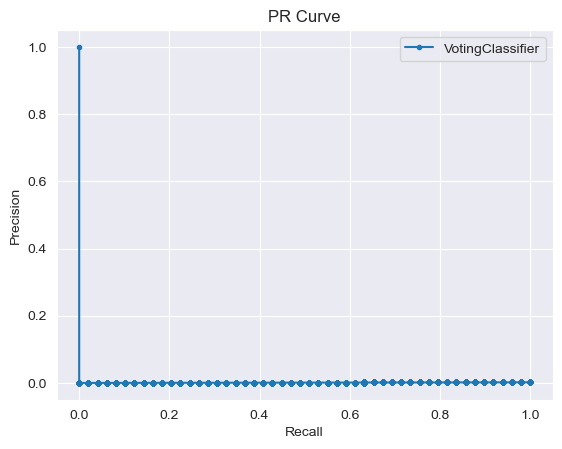

{'Model': 'VotingClassifier',
 'Title': 'VotingClassifier - Hyperparameter Tuned - (Train + Val)',
 'Parameters': 'LogReg + XGBoost params',
 'Accuracy': 0.9989817773252344,
 'Precision': 0.6785714285714286,
 'Recall': 0.7755102040816326,
 'F1 Score': 0.7238095238095238,
 'ROC AUC': 0.8874385573024932,
 'PRC AUC': 0.0010134517215617072,
 'Confusion Matrix': array([[28414,    18],
        [   11,    38]], dtype=int64)}

In [98]:
voting_ensemble.fit(
    X_train_smote, y_train_smote
)

# voting_ensemble.fit(
#     pd.concat([X_train, X_val]),
#     pd.concat([y_train, y_val])
# )

y_pred = voting_ensemble.predict(X_test)
print(f"VotingClassifier Accuracy: {accuracy_score(y_test, y_pred)} %")
print(classification_report(y_test, y_pred))
y_pred_probs = np.max(voting_ensemble.predict_proba(X_test), axis=1)
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
# PRs['VotingClassifier'] = {
#     'precision': precision,
#     'recall': recall,
#     'y_pred_probs': y_pred_probs
# }
plt.plot(recall, precision, marker='.', label='VotingClassifier')
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
print('='*50)
log_experiment(
    'VotingClassifier',
    y_pred,
    y_test,
    y_pred_probs,
    title=f'VotingClassifier - Hyperparameter Tuned - (Train + Val)',
    params='LogReg + XGBoost params' #str(voting_ensemble.get_params()['estimators'])
)

In [99]:
xgb_clf = XGBClassifier(
        n_estimators=500, learning_rate=0.01, 
        device='cuda:0', random_state=seed, 
        scale_pos_weight=sum(y_train==1)/sum(y_train==0)
    )

rf_clf = RandomForestClassifier(criterion='gini', n_estimators=200)

pipe_rf = Pipeline((
    ("preprocessor", ColumnTransformer([
        ("scaler", StandardScaler(), ["Amount", "Time"])
    ], remainder='passthrough')),
    ("clf", rf_clf)
))
pipe_rf.fit(X_train, y_train)
rf_probs = pipe_rf.predict_proba(X_test)[:, 1]
rf_preds = (rf_probs > 0.9).astype(int)

pipe_xgb = Pipeline((
    ("preprocessor", ColumnTransformer([
        ("scaler", StandardScaler(), ["Amount", "Time"])
    ], remainder='passthrough')),
    ("clf", xgb_clf)
))
pipe_xgb.fit(X_train, y_train)

xgb_probs = pipe_xgb.predict_proba(X_test)[:, 1]
xgb_preds = (xgb_probs > 0.5).astype(int)
low_confidence_mask = (xgb_probs > 0.4) & (xgb_probs < 0.6)

override_mask = (xgb_preds == 0) & (rf_preds == 1)
xgb_preds[override_mask] = 1

# Step 7: Evaluate final ensemble
print("Final Ensemble Evaluation:")
print(classification_report(y_test, xgb_preds))
print("Accuracy:", accuracy_score(y_test, xgb_preds))
log_experiment(
    'Ensemble - XGBoost + RandomForest',
    xgb_preds,
    y_test,
    xgb_probs,
    title='Ensamble(XGBoost + RandomForest) - Hyperparameter Tuned',
    params='XGBoost + RandomForest'
)

Final Ensemble Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       1.00      0.45      0.62        49

    accuracy                           1.00     28481
   macro avg       1.00      0.72      0.81     28481
weighted avg       1.00      1.00      1.00     28481

Accuracy: 0.9990519995786665


{'Model': 'Ensemble - XGBoost + RandomForest',
 'Title': 'Ensamble(XGBoost + RandomForest) - Hyperparameter Tuned',
 'Parameters': 'XGBoost + RandomForest',
 'Accuracy': 0.9990519995786665,
 'Precision': 1.0,
 'Recall': 0.4489795918367347,
 'F1 Score': 0.6197183098591549,
 'ROC AUC': 0.7244897959183674,
 'PRC AUC': 0.6570705087725099,
 'Confusion Matrix': array([[28432,     0],
        [   27,    22]], dtype=int64)}

# Chapter Six: Anomaly Detection

In [135]:
iso_forest = IsolationForest(contamination=0.01, random_state=seed)

In [136]:
X_not_fraud = X_train[y_train == 0]
X_fraud = X_train[y_train == 1]

In [141]:
iso_forest.fit(X_not_fraud)
y_pred_iso = iso_forest.predict(X_val)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1)  # Convert -1 to 1 (fraud) and 1 to 0 (not fraud)
print(f"IsolationForest Val Accuracy: {accuracy_score(y_val, y_pred_iso) *100} %")

IsolationForest Val Accuracy: 98.96071064920473 %


In [143]:
y_pred_iso_test = iso_forest.predict(X_test)
y_pred_iso_test = np.where(y_pred_iso_test == 1, 0, 1)  # Convert -1 to 1 (fraud) and 1 to 0 (not fraud)
print(f"IsolationForest Test Accuracy: {accuracy_score(y_test, y_pred_iso_test) *100} %")

IsolationForest Test Accuracy: 98.96071064920473 %


In [147]:
log_experiment(
    'IsolationForest',
    y_pred_iso_test,
    y_test,
    y_pred_iso_test,
    title='IsolationForest',
    params=str(iso_forest.get_params())
)

{'Model': 'IsolationForest',
 'Title': 'IsolationForest',
 'Parameters': "{'bootstrap': False, 'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 1337, 'verbose': 0, 'warm_start': False}",
 'Accuracy': 0.9896071064920473,
 'Precision': 0.07849829351535836,
 'Recall': 0.46938775510204084,
 'F1 Score': 0.13450292397660818,
 'ROC AUC': 0.7299457064761752,
 'PRC AUC': 0.27439946895600836,
 'Confusion Matrix': array([[28162,   270],
        [   26,    23]], dtype=int64)}

In [151]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [152]:
X_not_fraud = X_train_scaled[y_train == 0]
iso_forest.fit(X_not_fraud)

IsolationForest(contamination=0.01, random_state=1337)

In [154]:
iso_forest.decision_function(X_train_scaled)

array([0.18443309, 0.19811406, 0.21353617, ..., 0.18557341, 0.20577071,
       0.17648122])

In [156]:
X_train['anomaly_score'] = iso_forest.decision_function(X_train_scaled)
X_val['anomaly_score'] = iso_forest.decision_function(X_val_scaled)
X_test['anomaly_score'] = iso_forest.decision_function(X_test_scaled)

XGBoost + ISO Forest Accuracy: 0.9989817773252344 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.68      0.78      0.72        49

    accuracy                           1.00     28481
   macro avg       0.84      0.89      0.86     28481
weighted avg       1.00      1.00      1.00     28481



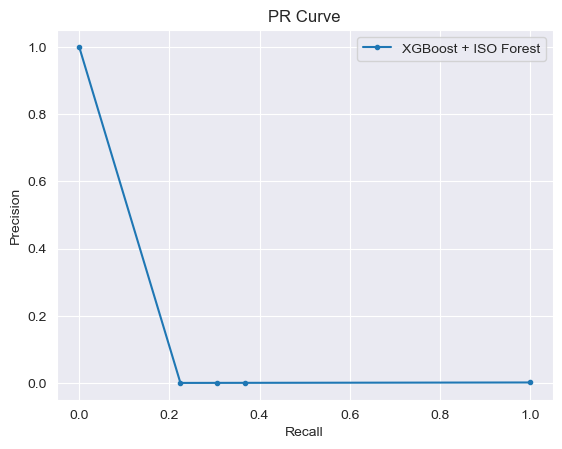

{'Model': 'XGBoost + ISO Forest',
 'Title': 'XGBoost + ISO Forest',
 'Parameters': "{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda:0', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 1337, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 0.0017322412299792043, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': No

In [160]:
xgb_clf = XGBClassifier(
    n_estimators=500, learning_rate=0.01, 
    device='cuda:0', random_state=seed, 
    scale_pos_weight=sum(y_train==1)/sum(y_train==0)
)
xgb_clf.fit(X_train, y_train)


y_pred_xgb = xgb_clf.predict(X_test) 
print(f"XGBoost + ISO Forest Accuracy: {accuracy_score(y_test, y_pred)} %")
print(classification_report(y_test, y_pred))
y_pred_probs = np.max(xgb_clf.predict_proba(X_test), axis=1)
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)


plt.plot(recall, precision, marker='.', label='XGBoost + ISO Forest')
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
print('='*50)
log_experiment(
    'XGBoost + ISO Forest',
    y_pred,
    y_test,
    y_pred_probs,
    title=f'XGBoost + ISO Forest',
    params=str(xgb_clf.get_params())
)

### DBSCAN

In [163]:
# from sklearn.cluster import DBSCAN
# db = DBSCAN(eps=15, min_samples=4)
# X['cluster'] = db.fit_predict(X)
# X['cluster'].value_counts()

## Stacking Classifier

In [164]:
best_models

[{'Model': 'LogisticRegression',
  'Best Params': {'clf__class_weight': 'balanced', 'clf__max_iter': 500},
  'Best Score': 0.9061343719571567},
 {'Model': 'RandomForest',
  'Best Params': {'clf__class_weight': None,
   'clf__criterion': 'gini',
   'clf__n_estimators': 200},
  'Best Score': 0.7817267121064589},
 {'Model': 'XGBoost',
  'Best Params': {'clf__learning_rate': 0.01, 'clf__n_estimators': 500},
  'Best Score': 0.7716001298279779},
 {'Model': 'MLP',
  'Best Params': {'clf__activation': 'tanh',
   'clf__hidden_layer_sizes': (10, 20, 50, 100),
   'clf__learning_rate': 'adaptive',
   'clf__max_iter': 200,
   'clf__solver': 'adam'},
  'Best Score': 0.7489126906848427}]

In [170]:
from sklearn.ensemble import StackingClassifier

stacked_clf = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(
            n_estimators=500, learning_rate=0.01, 
            device='cuda:0', random_state=seed, 
            scale_pos_weight=sum(y_train==1)/sum(y_train==0)
        )), 
        ('rf', RandomForestClassifier(criterion='gini', n_estimators=200)),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(10, 20, 50, 100),
            learning_rate='adaptive',
            max_iter=200, solver='adam'
        )),
    ],
)


In [171]:
stacked_clf.fit(
    X_train_smote, y_train_smote
)

y_pred = stacked_clf.predict(X_test)
print(f"StackedClassifier Accuracy: {accuracy_score(y_test, y_pred)} %")
print(classification_report(y_test, y_pred))
y_pred_probs = np.max(stacked_clf.predict_proba(X_test), axis=1)
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.plot(recall, precision, marker='.', label='StackedClassifier')
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
print('='*50)
log_experiment(
    'StackedClassifier',
    y_pred,
    y_test,
    y_pred_probs,
    title=f'StackedClassifier - ( SMOTE)',
    params=str(stacked_clf.get_params()['estimators'])
)

KeyboardInterrupt: 

StackedClassifier Accuracy: 0.9995084442259752 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       1.00      0.71      0.83        49

    accuracy                           1.00     28481
   macro avg       1.00      0.86      0.92     28481
weighted avg       1.00      1.00      1.00     28481



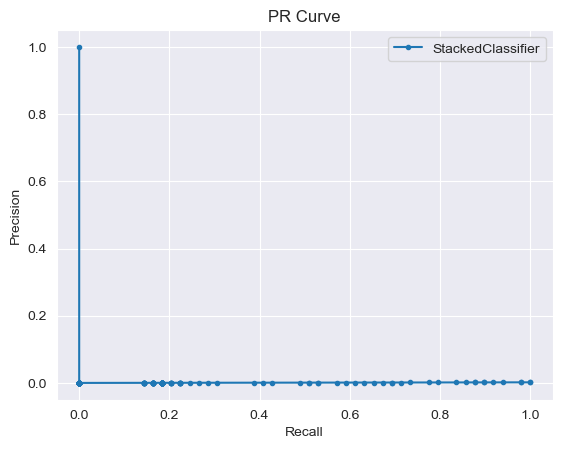

{'Model': 'StackedClassifier',
 'Title': 'StackedClassifier - (Train + Val)',
 'Parameters': [('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device='cuda:0',
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=None,
                 grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=500, n_jobs=None,
                 num_parallel_tree=None, random_state=1337, ...)),
  ('rf', RandomForestClassifier(n_estimators=200)),
  ('mlp',
   MLPClassifier(hidden

In [178]:
stacked_clf.fit(
    pd.concat([X_train, X_val]),
    pd.concat([y_train, y_val])
)

y_pred = stacked_clf.predict(X_test)
print(f"StackedClassifier Accuracy: {accuracy_score(y_test, y_pred)} %")
print(classification_report(y_test, y_pred))
y_pred_probs = np.max(stacked_clf.predict_proba(X_test), axis=1)
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.plot(recall, precision, marker='.', label='StackedClassifier')
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
print('='*50)
log_experiment(
    'StackedClassifier',
    y_pred,
    y_test,
    y_pred_probs,
    title=f'StackedClassifier - (Train + Val)',
    params=stacked_clf.get_params()['estimators']
)

In [179]:
stacked_clf.get_params()['estimators']

[('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device='cuda:0',
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.01, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=500, n_jobs=None,
                num_parallel_tree=None, random_state=1337, ...)),
 ('rf', RandomForestClassifier(n_estimators=200)),
 ('mlp',
  MLPClassifier(hidden_layer_sizes=(10, 20, 50, 100), learning_rate='adaptive'))]

# Model Comparisons

In [176]:
results_df = pd.DataFrame(EXPERIMENTS)
results_df

,Model,Title,Parameters,Accuracy,Precision,Recall,F1 Score,ROC AUC,PRC AUC,Confusion Matrix
0,LogisticRegression,Logistic Regression (Baseline),"LogisticRegression(max_iter=1000, random_state...",0.991608,0.160714,0.918367,0.273556,0.955051,0.472295,"[[28197, 235], [4, 45]]"
1,LogisticRegression,Logistic Regression (Baseline) - class_weight=...,"LogisticRegression(class_weight='balanced', ma...",0.991608,0.160714,0.918367,0.273556,0.955051,0.472295,"[[28197, 235], [4, 45]]"
2,RandomForest,RandomForest - Basic - SMOTE,RandomForestClassifier(random_state=1337),0.999579,0.893617,0.857143,0.875000,0.928483,0.194770,"[[28427, 5], [7, 42]]"
3,XgBoost,XgBoost - Basic - SMOTE,"XGBClassifier(base_score=None, booster=None, c...",0.999614,0.895833,0.877551,0.886598,0.938688,0.001025,"[[28427, 5], [6, 43]]"
4,LogisticRegression,LogisticRegression - Hyperparameter Tuned - (T...,"LogisticRegression(class_weight='balanced', ma...",0.978336,0.065749,0.877551,0.122333,0.928031,0.439269,"[[27821, 611], [6, 43]]"
5,RandomForest,RandomForest - Hyperparameter Tuned - (Train +...,"RandomForestClassifier(n_estimators=200, n_job...",0.999473,0.947368,0.734694,0.827586,0.867312,0.082496,"[[28430, 2], [13, 36]]"
6,XGBoost,XGBoost - Hyperparameter Tuned - (Train + Val),"XGBClassifier(base_score=None, booster=None, c...",0.999544,1.000000,0.734694,0.847059,0.867347,0.000863,"[[28432, 0], [13, 36]]"
7,MLP,MLP - Hyperparameter Tuned - (Train + Val),"MLPClassifier(activation='tanh', early_stoppin...",0.999157,0.790698,0.693878,0.739130,0.846781,0.000864,"[[28423, 9], [15, 34]]"
8,VotingClassifier,VotingClassifier - Hyperparameter Tuned - (Tra...,LogReg + XGBoost params,0.998982,0.678571,0.775510,0.723810,0.887439,0.001013,"[[28414, 18], [11, 38]]"
9,Ensemble - XGBoost + RandomForest,Ensamble(XGBoost + RandomForest) - Hyperparame...,XGBoost + RandomForest,0.999052,1.000000,0.448980,0.619718,0.724490,0.657071,"[[28432, 0], [27, 22]]"


In [177]:
results_df.to_csv('credit_card_fraud_detection_results.csv', index=False)
# Save the model
# import joblib
# joblib.dump(stacked_clf, 'credit_card_fraud_detection_model.pkl')

<Axes: title={'center': 'Model Performance Comparison'}, ylabel='Title'>

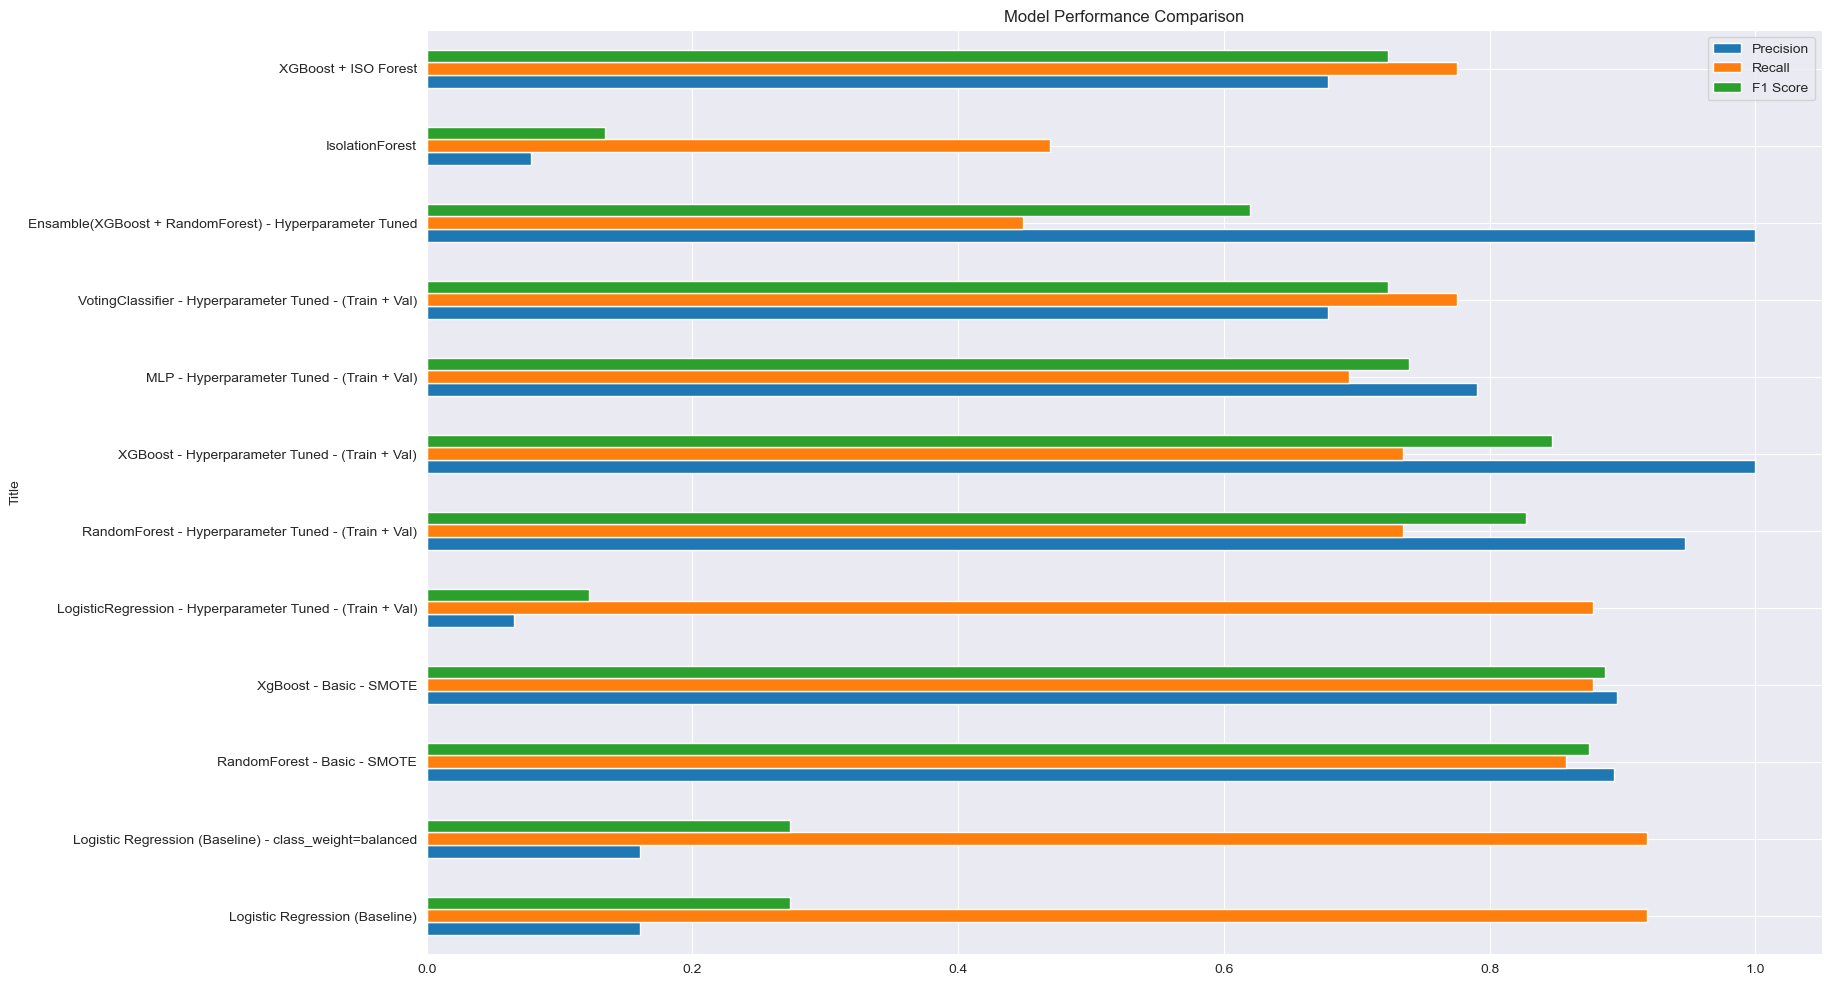

In [162]:
results_df.plot(
    x='Title', 
    y=['Precision', 'Recall', 'F1 Score'], 
    kind='barh',
    figsize=(18, 12),
    title='Model Performance Comparison'
)